## Q1

Data Analysis.<br>
Concerns about the data.<br>
Suggestions on other useful data to collect.

In [313]:
# Import libraries for processing
import pandas as pd
import numpy as np
import seaborn as sns
from numpy import mean
from numpy import std

from plotly.offline import iplot
import plotly.graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff

from collections import defaultdict

from pandas.plotting import scatter_matrix

import matplotlib.pyplot as plt
%matplotlib inline

from scipy.stats import norm

# Import libraries for modelling
import sklearn
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedKFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_squared_error

import warnings
warnings.simplefilter(action='ignore', category=RuntimeWarning)

In [314]:
#Functions & Utils
numerical = ['crime_rate', 'proportion_flats', 'proportion_nonretail', 'commercial_property', 'household_size', 
             'proportion_newbuilds', 'public_transport_dist', 'property_value', 'school_proximity', 'competitor_density', 
             'household_affluency']

categorical = ['new_store','transport_availability', 'county']

target = ['normalised_sales']

all_num = numerical + target
all_cat = categorical + target

def dataframe_selector(df, column_list):
    return pd.DataFrame(df, columns=column_list)

def data_to_numeric(df):
    return df.apply(pd.to_numeric)

def rescale_data(df):
    scaler = MinMaxScaler(feature_range=(0,1))
    scaled = scaler.fit_transform(df)
    df_scaled = pd.DataFrame(scaled, columns = df.columns)
    return df_scaled

def one_hot_encode(df):
    df_1_hot = pd.get_dummies(df, columns = df.columns.tolist())
    return df_1_hot

def extract_or_remove_by_column(df, val, col_name, choice):
    if choice == 'remove' and val == 'NA':
        df= df[df[col_name].isnull() == False]
        return df
    elif choice == 'remove':
        df= df[df[col_name] != val]
        return df
    elif choice == 'extract' and val == 'NA':
        df= df[df[col_name].isnull()]
        return df
    elif choice == 'extract':
        df= df[df[col_name] == val]
        return df
        
def value_count(df, value):
    val_count = {}
    if value == 'NA':
        for col in df.columns:
            col_value = 0
            for val in df[col].isnull():
                if val == True:
                    col_value += 1
            val_count[col] = [col_value, '{:0.2f}%'.format((float(col_value)/len(df))*100)]
        return val_count
    else:
        for col in df.columns:
            col_value = 0
            for val in df[col] == value:
                if val == True:
                    col_value += 1
            val_count[col] = [col_value, '{:0.2f}%'.format((float(col_value)/len(df))*100)]
        return val_count
    
def fill_col_with_median(df):
    for col in df.columns:
        df[col] = df[col].fillna(df[col].median())
    return df

def remove_outliers(df):
    for col in df.columns:
        df[col] = replace_outlier(df[col])
    return df

def mad_based_outlier(points, thresh=3.5):
    if len(points.shape) == 1:
        points = points[:,None]
    median = np.median(points, axis=0)
    diff = np.sum((points - median)**2, axis=-1)
    diff = np.sqrt(diff)
    med_abs_deviation = np.median(diff)
    modified_z_score = 0.6745 * diff / med_abs_deviation
    return modified_z_score > thresh

def percentile_based_outlier(data, threshold=95):
    diff = (100 - threshold) / 2.0
    (min_val, max_val) = np.percentile(data, [diff, 100 - diff])
    return ((data < min_val) | (data > max_val))

def std_div(data, threshold=3):
    std = data.std()
    mean = data.mean()
    is_outlier = []
    for val in data:
        if val/std > threshold:
            is_outlier.append(True)
        else:
            is_outlier.append(False)
    return is_outlier

def outlier_vote(data):
    x = percentile_based_outlier(data)
    y = mad_based_outlier(data)
    z = std_div(data)
    temp = list(zip(data.index, x, y, z))
    final = []
    for i in range(len(temp)):
        if temp[i].count(False) >= 2:
            final.append(False)
        else:
            final.append(True)
    return final

def plot_outlier(x):
    fig, axes = plt.subplots(nrows=4)
    for ax, func in list(zip(axes, [percentile_based_outlier, mad_based_outlier, std_div, outlier_vote])):
        sns.distplot(x, ax=ax, rug=True, hist=False)
        outliers = x[func(x)]
        ax.plot(outliers, np.zeros_like(outliers), 'ro', clip_on=False)

    kwargs = dict(y=0.95, x=0.05, ha='left', va='top', size=20)
    axes[0].set_title('Percentile based outliers', **kwargs)
    axes[1].set_title('MAD based outliers', **kwargs)
    axes[2].set_title('STD based outliers', **kwargs)
    axes[3].set_title('Majority vote based outliers', **kwargs)
    fig.suptitle('Comparing outlier tests with n={}'.format(len(x)), size=20)
    fig = plt.gcf()
    fig.set_size_inches(15,10)
    
def plot_outlier_free(x):
    fig, axes = plt.subplots(nrows=4)
    n_outliers = []
    for ax, func in list(zip(axes, [percentile_based_outlier, mad_based_outlier, std_div, outlier_vote])):
        tf_outlier = list(zip(x, func(x)))
        n_outliers.append(len([index for (index, bol) in tf_outlier if bol == True]))
        outlier_free = [index for (index, bol) in tf_outlier if bol == True]
        sns.distplot(outlier_free, ax=ax, rug=True, hist=False)
        
    kwargs = dict(y=0.95, x=0.05, ha='left', va='top', size=15)
    axes[0].set_title('Percentile based outliers, removed: {r}'.format(r=n_outliers[0]), **kwargs)
    axes[1].set_title('MAD-based outliers, removed: {r}'.format(r=n_outliers[1]), **kwargs)
    axes[2].set_title('STD-based outliers, removed: {r}'.format(r=n_outliers[2]), **kwargs)
    axes[3].set_title('Majority vote based outliers, removed: {r}'.format(r=n_outliers[3]), **kwargs)
    fig.suptitle('Outlier removed by method with n={}'.format(len(x)), size=20)
    fig = plt.gcf()
    fig.set_size_inches(15,10)

def outlier_ratio(data):
    functions = [percentile_based_outlier, mad_based_outlier, std_div, outlier_vote]
    outlier_dict = {}
    for func in functions:
        func_result = func(data)
        count = 0
        for val in func_result:
            if val == True:
                count += 1 
        outlier_dict[str(func)[10:].split()[0]] = [count, '{:.2f}%'.format((float(count)/len(data))*100)]
    
    return outlier_dict

def replace_outlier(data, method = outlier_vote, replace='median'):
    '''replace: median (auto)
    'min_upper' which is the upper bound of the outlier detection'''
    vote = outlier_vote(data)
    x = pd.DataFrame(list(zip(data, vote)), columns=['place_holder', 'outlier'])
    if replace == 'median':
        replace = x['place_holder'].median()
    elif replace == 'min_upper':
        replace = min([val for (val, vote) in list(zip(data, vote)) if vote == True])
        if replace < data.mean():
            return 'There are outliers lower than the sample mean'
    place_holder_new = []
    for i in range(x.shape[0]):
        if x.iloc[i][1] == True:
            place_holder_new.append(replace)
        else:
            place_holder_new.append(x.iloc[i][0])
    return place_holder_new

def all_outliers(data):
    outliers_dict = defaultdict(dict)
    for col in data.columns:
        outliers_dict[col] = outlier_ratio(data[col])
    return outliers_dict

### Take a look at the dataset and get summary statistics

In [315]:
# Load data
stores = pd.read_csv('train.csv')

In [316]:
# Take a look at the first few rows
stores.head()

,location_id,crime_rate,proportion_flats,proportion_nonretail,new_store,commercial_property,household_size,proportion_newbuilds,public_transport_dist,transport_availability,property_value,school_proximity,competitor_density,household_affluency,normalised_sales,county
0,464,17.600541,0.0,18.10,no,NaN,2.926,29.0,2.9084,All transport options,666,20.2,368.74,4.5325,-0.399933,c_40
1,504,0.603556,20.0,3.97,no,14.85,4.520,10.6,2.1398,Average transport options,264,13.0,388.37,1.8150,2.216308,c_80
2,295,0.606810,0.0,6.20,no,7.70,2.981,31.9,3.6715,Many transport options,307,17.4,378.35,2.9125,0.166920,c_53
3,187,0.012385,55.0,2.25,no,1.95,3.453,68.1,7.3073,No transport options,300,15.3,394.72,2.0575,-0.083804,c_65
4,193,0.016182,100.0,1.32,no,3.05,3.816,59.5,8.3248,Average transport options,256,15.1,392.90,0.9875,0.962693,c_97


Data dict as given<br>

location_id: id of Tesco property location<br>
normalised_sales: normalised sales value of Tesco store<br>
crime_rate: crime rate in the area<br>
household_size: mean household size in the area<br>
household_affluency: mean household affluency in the area<br>
public_transport_dist: index of public transport availability in the area<br>
proportion_newbuilds: proportion of newly built property in the area<br>
property_value: average property value in the area<br>
commercial_property: percentage of commercial properties in the area<br>
school_proximity: average school proximity in the area<br>
transport_proximity: proximity of different transport modes<br>
new_store: new Tesco store opened recently<br>
proportion_nonretail: proportion of non-retail commercial properties in the area<br>
competitor_density: density of competitor retailers<br>
proportion_flats: proportion of blocks of flats in the area<br>
county: county code of the area

In [317]:
# Check data types
stores.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 320 entries, 0 to 319
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   location_id             320 non-null    int64  
 1   crime_rate              320 non-null    float64
 2   proportion_flats        320 non-null    float64
 3   proportion_nonretail    320 non-null    float64
 4   new_store               320 non-null    object 
 5   commercial_property     291 non-null    float64
 6   household_size          320 non-null    float64
 7   proportion_newbuilds    320 non-null    float64
 8   public_transport_dist   320 non-null    float64
 9   transport_availability  320 non-null    object 
 10  property_value          320 non-null    int64  
 11  school_proximity        257 non-null    float64
 12  competitor_density      320 non-null    float64
 13  household_affluency     320 non-null    float64
 14  normalised_sales        320 non-null    fl

In [318]:
# Data types look ok, check summary stats
stores.describe()

,location_id,crime_rate,proportion_flats,proportion_nonretail,commercial_property,household_size,proportion_newbuilds,public_transport_dist,property_value,school_proximity,competitor_density,household_affluency,normalised_sales
count,320.000000,320.000000,320.000000,320.000000,291.000000,320.000000,320.000000,320.000000,320.000000,257.000000,320.000000,320.000000,320.000000
mean,252.387500,3.596375,10.673438,11.307906,16.868557,3.252803,31.849063,3.718765,408.834375,18.589494,359.657562,3.144008,-0.016967
std,145.600582,7.176342,22.579232,7.032693,73.806051,0.695442,27.845777,1.984765,170.888974,2.075529,86.048632,1.774041,0.978561
min,1.000000,0.007142,0.000000,0.740000,1.750000,0.561000,0.000000,1.137000,188.000000,13.000000,3.500000,0.432500,-1.936974
25%,126.500000,0.087937,0.000000,5.130000,5.450000,2.879750,6.350000,2.138075,277.000000,17.400000,376.722500,1.803750,-0.585250
50%,251.500000,0.289681,0.000000,9.900000,9.400000,3.197500,23.400000,3.095750,330.000000,19.100000,392.205000,2.808750,-0.143759
75%,377.250000,4.063553,12.500000,18.100000,14.050000,3.597250,54.450000,5.116700,666.000000,20.200000,396.352500,4.091875,0.243227
max,506.000000,51.693093,100.000000,27.740000,1009.000000,5.725000,94.000000,10.710300,711.000000,21.200000,396.900000,9.492500,2.968477


commercial_property has at least 1 value greater than 100% at 1009%

In [319]:
#stores['commercial_property'].value_counts()
stores.loc[stores['commercial_property'] > 100].head()
#stores.loc[stores['commercial_property'] > 100].count()
#stores['commercial_property'].loc[stores['commercial_property'] > 100].count()

,location_id,crime_rate,proportion_flats,proportion_nonretail,new_store,commercial_property,household_size,proportion_newbuilds,public_transport_dist,transport_availability,property_value,school_proximity,competitor_density,household_affluency,normalised_sales,county
96,90,0.138640,0.0,6.91,no,1009.0,3.069,60.0,5.7209,No transport options,233,17.9,389.39,2.3875,-0.171012,c_48
103,394,0.102864,0.0,2.46,no,123.0,4.155,7.8,2.7006,No transport options,193,NaN,394.12,1.2050,1.649456,c_68
224,283,10.541872,0.0,18.10,no,767.0,3.185,1.3,2.2616,All transport options,666,20.2,396.90,4.5325,-0.944983,c_45


In [320]:
#sns.boxplot(data = stores, y = 'commercial_property')
fig = px.box(stores, y="commercial_property", points='all')
fig.show()

I've decided to not delete these rows as I believe they are data entry errors. The other values in the rows where the commercial_property oultiers occur seem reasonable. I will replace the values with a high value, mean or median when outliers are removed

### Find missing data and clean dataset

In [321]:
# Find missing data
value_count(stores, 'NA')
#stores.isnull().sum()

{'location_id': [0, '0.00%'],
 'crime_rate': [0, '0.00%'],
 'proportion_flats': [0, '0.00%'],
 'proportion_nonretail': [0, '0.00%'],
 'new_store': [0, '0.00%'],
 'commercial_property': [29, '9.06%'],
 'household_size': [0, '0.00%'],
 'proportion_newbuilds': [0, '0.00%'],
 'public_transport_dist': [0, '0.00%'],
 'transport_availability': [0, '0.00%'],
 'property_value': [0, '0.00%'],
 'school_proximity': [63, '19.69%'],
 'competitor_density': [0, '0.00%'],
 'household_affluency': [0, '0.00%'],
 'normalised_sales': [0, '0.00%'],
 'county': [0, '0.00%']}

commercial_property is missing 9.06% and school_proximity is missing 19.69%

commercial_property and school proximity_variables. Compare mean v median as replacement.

In [322]:
# mean
ns_mean = stores['normalised_sales'].fillna(stores['normalised_sales'].mean())
cp_mean = stores['commercial_property'].fillna(stores['commercial_property'].mean())
sp_mean = stores['school_proximity'].fillna(stores['school_proximity'].mean())
# median
ns_median = stores['normalised_sales'].fillna(stores['normalised_sales'].median())
cp_median = stores['commercial_property'].fillna(stores['commercial_property'].median())
sp_median = stores['school_proximity'].fillna(stores['school_proximity'].median())

cp_missing_joint = stores['normalised_sales'].isnull() | stores['commercial_property'].isnull()
sp_missing_joint = stores['normalised_sales'].isnull() | stores['school_proximity'].isnull()

In [323]:
# create a dictionary to indicate different colors, missing values will be orange
colour_choice_dict = {True: (1.0, 0.55, 0.0, 1.0), False: (0.11, 0.65, 0.72, 0.1)}
# create a column with color values
colour_col = [colour_choice_dict[val] for val in cp_missing_joint]

Text(0, 0.5, 'normalised_sales')

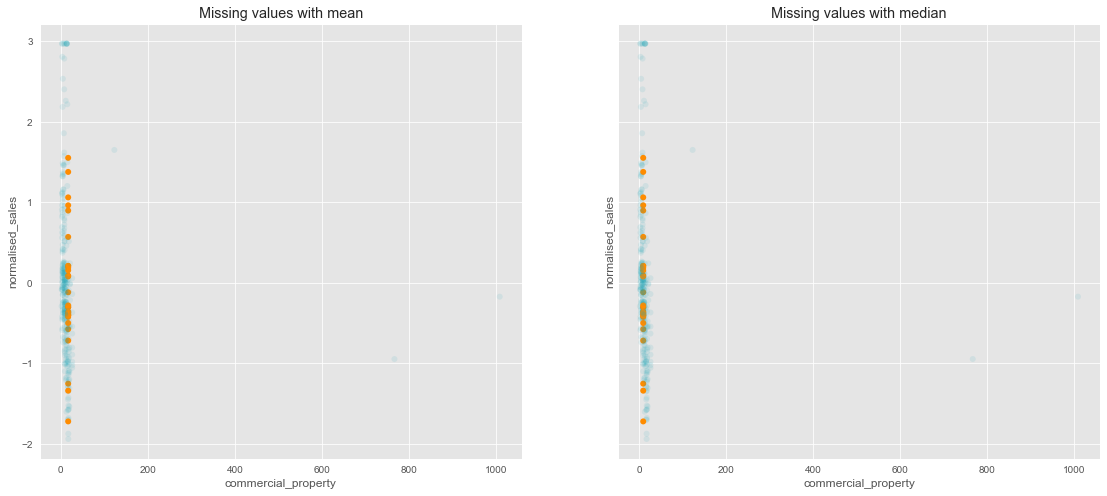

In [324]:
plt.style.use('ggplot')

f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(19, 8))
ax1.scatter(cp_mean, ns_mean, c = colour_col, linewidth=0)
ax1.set_title('Missing values with mean')
ax1.set_xlabel('commercial_property')
ax1.set_ylabel('normalised_sales')
ax2.scatter(cp_median, ns_median, c = colour_col, linewidth=0)
ax2.set_title('Missing values with median')
ax2.set_xlabel('commercial_property')
ax2.set_ylabel('normalised_sales')

We can see where the imputed values will be.There does not seem to be a big difference. Choose median as values are less sensitive to outliers.

Text(0, 0.5, 'normalised_sales')

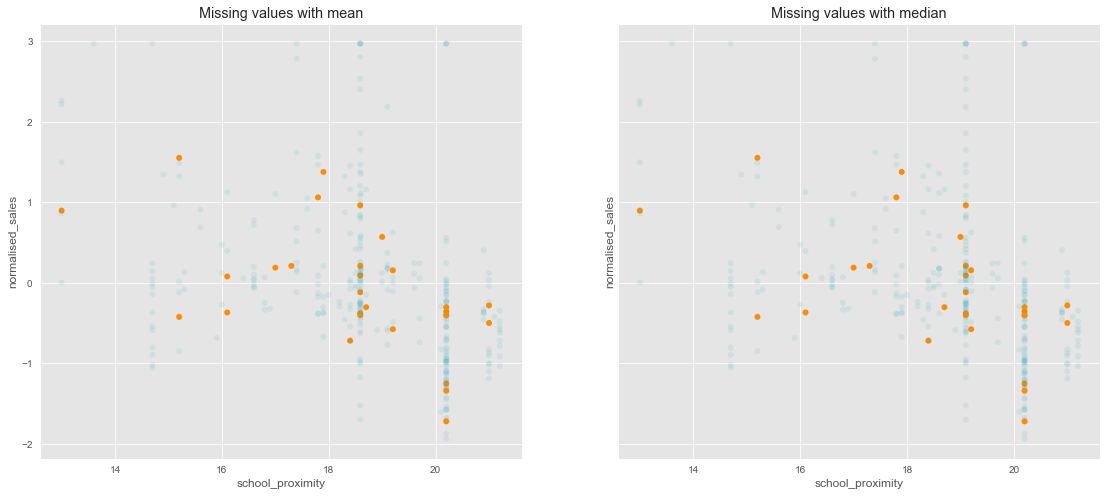

In [325]:
plt.style.use('ggplot')

f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(19, 8))
ax1.scatter(sp_mean, ns_mean, c = colour_col, linewidth=0)
ax1.set_title('Missing values with mean')
ax1.set_xlabel('school_proximity')
ax1.set_ylabel('normalised_sales')
ax2.scatter(sp_median, ns_median, c = colour_col, linewidth=0)
ax2.set_title('Missing values with median')
ax2.set_xlabel('school_proximity')
ax2.set_ylabel('normalised_sales')

Same as commercial_property, use median.

In [326]:
# Replace missing values with median
stores['commercial_property']= stores['commercial_property'].fillna(stores['commercial_property'].median())
stores['school_proximity']= stores['school_proximity'].fillna(stores['school_proximity'].median())

In [327]:
value_count(stores, 'NA')

{'location_id': [0, '0.00%'],
 'crime_rate': [0, '0.00%'],
 'proportion_flats': [0, '0.00%'],
 'proportion_nonretail': [0, '0.00%'],
 'new_store': [0, '0.00%'],
 'commercial_property': [0, '0.00%'],
 'household_size': [0, '0.00%'],
 'proportion_newbuilds': [0, '0.00%'],
 'public_transport_dist': [0, '0.00%'],
 'transport_availability': [0, '0.00%'],
 'property_value': [0, '0.00%'],
 'school_proximity': [0, '0.00%'],
 'competitor_density': [0, '0.00%'],
 'household_affluency': [0, '0.00%'],
 'normalised_sales': [0, '0.00%'],
 'county': [0, '0.00%']}

In [328]:
value_count(stores, 0)

{'location_id': [0, '0.00%'],
 'crime_rate': [0, '0.00%'],
 'proportion_flats': [238, '74.38%'],
 'proportion_nonretail': [0, '0.00%'],
 'new_store': [0, '0.00%'],
 'commercial_property': [0, '0.00%'],
 'household_size': [0, '0.00%'],
 'proportion_newbuilds': [23, '7.19%'],
 'public_transport_dist': [0, '0.00%'],
 'transport_availability': [0, '0.00%'],
 'property_value': [0, '0.00%'],
 'school_proximity': [0, '0.00%'],
 'competitor_density': [0, '0.00%'],
 'household_affluency': [0, '0.00%'],
 'normalised_sales': [0, '0.00%'],
 'county': [0, '0.00%']}

### Outliers

In [329]:
#create palette
my_palette = ["#1E90FF", "#FFD700", "#00EEEE", "#668B8B", "#EAEAEA", "#FF3030"]
sns.set_palette(my_palette)
#sns.palplot(sns.color_palette())

Commercial Property

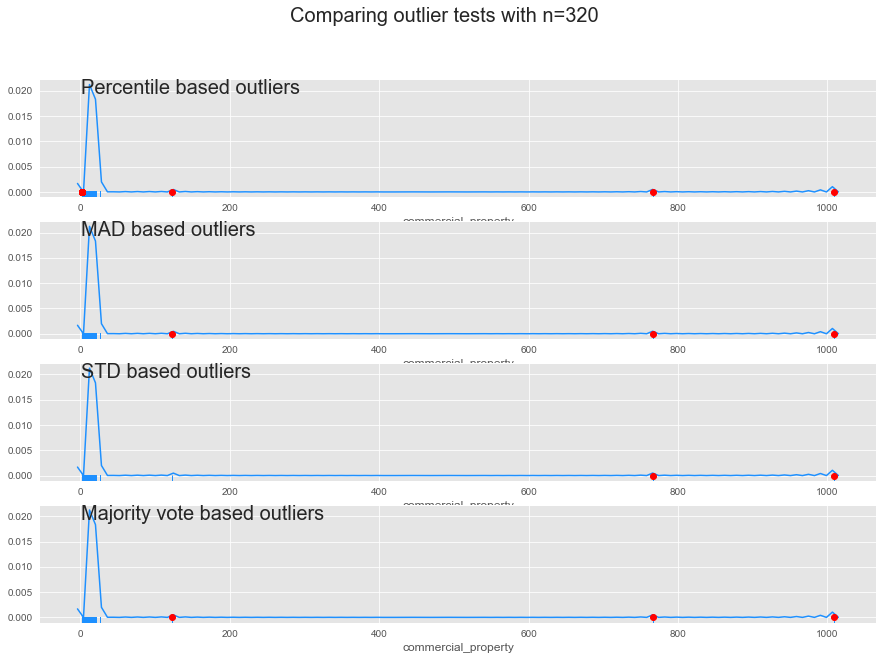

In [330]:
plot_outlier(stores['commercial_property'].sample(320))

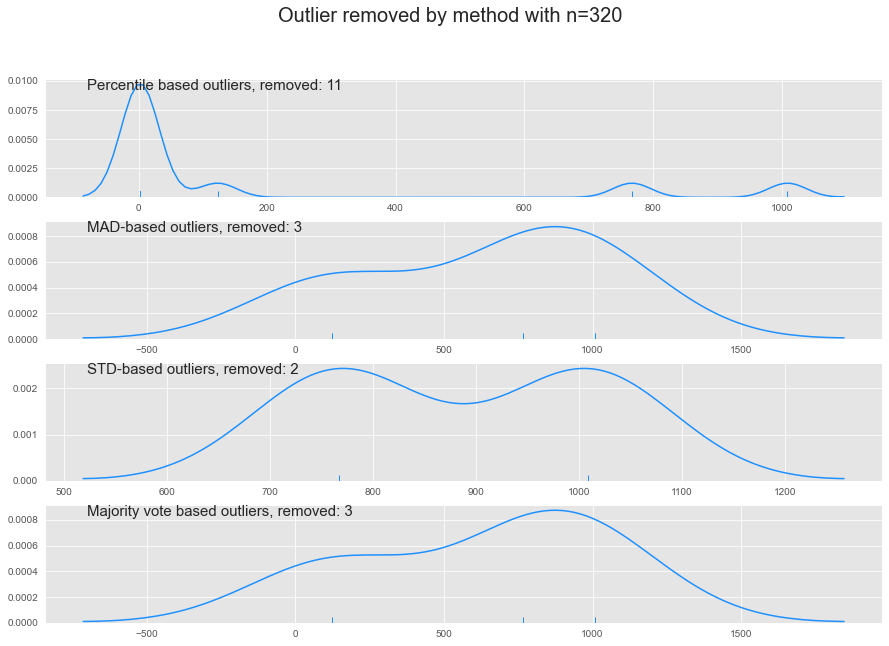

In [331]:
plot_outlier_free(stores['commercial_property'].sample(320))

In [332]:
new_commercial_property = replace_outlier(stores['commercial_property'], replace='median')

In [333]:
stores['commercial_property'] = new_commercial_property
stores['commercial_property'].loc[stores['commercial_property'] > 100].count()

0

School Proximity

In [334]:
outlier_ratio(stores['school_proximity'])

{'percentile_based_outlier': [7, '2.19%'],
 'mad_based_outlier': [6, '1.88%'],
 'std_div': [320, '100.00%'],
 'outlier_vote': [7, '2.19%']}

In [335]:
new_school_proximity = replace_outlier(stores['school_proximity'], replace='median')
stores['school_proximity'] = new_school_proximity
#stores['school_proximity'].describe()

Crime Rate

In [336]:
outlier_ratio(stores['crime_rate'])

{'percentile_based_outlier': [15, '4.69%'],
 'mad_based_outlier': [105, '32.81%'],
 'std_div': [11, '3.44%'],
 'outlier_vote': [11, '3.44%']}

In [337]:
new_crime_rate = replace_outlier(stores['crime_rate'], replace='median')
stores['crime_rate'] = new_crime_rate
#stores['crime_rate'].describe()

Proportion Flats

In [338]:
outlier_ratio(stores['proportion_flats'])

{'percentile_based_outlier': [8, '2.50%'],
 'mad_based_outlier': [82, '25.62%'],
 'std_div': [19, '5.94%'],
 'outlier_vote': [19, '5.94%']}

In [339]:
new_proportion_flats = replace_outlier(stores['proportion_flats'], replace='median')
stores['proportion_flats'] = new_proportion_flats
#stores['proportion_flats'].describe()

Proportion Nonretail

In [340]:
outlier_ratio(stores['proportion_nonretail'])

{'percentile_based_outlier': [11, '3.44%'],
 'mad_based_outlier': [0, '0.00%'],
 'std_div': [20, '6.25%'],
 'outlier_vote': [4, '1.25%']}

In [341]:
new_proportion_nonretail = replace_outlier(stores['proportion_nonretail'], replace='median')
stores['proportion_nonretail'] = new_proportion_nonretail
#stores['proportion_nonretail'].describe()

Household Size

In [342]:
outlier_ratio(stores['household_size'])

{'percentile_based_outlier': [16, '5.00%'],
 'mad_based_outlier': [11, '3.44%'],
 'std_div': [306, '95.62%'],
 'outlier_vote': [12, '3.75%']}

In [343]:
new_household_size = replace_outlier(stores['household_size'], replace='median')
stores['household_size'] = new_household_size
#stores['household_size'].describe()

Proportion Newbuilds

In [344]:
outlier_ratio(stores['proportion_newbuilds'])

{'percentile_based_outlier': [8, '2.50%'],
 'mad_based_outlier': [0, '0.00%'],
 'std_div': [14, '4.38%'],
 'outlier_vote': [8, '2.50%']}

In [345]:
new_proportion_newbuilds = replace_outlier(stores['proportion_newbuilds'], replace='median')
stores['proportion_newbuilds'] = new_proportion_newbuilds
#stores['proportion_newbuilds'].describe()

Public Transport Dist

In [346]:
outlier_ratio(stores['public_transport_dist'])

{'percentile_based_outlier': [16, '5.00%'],
 'mad_based_outlier': [3, '0.94%'],
 'std_div': [53, '16.56%'],
 'outlier_vote': [8, '2.50%']}

In [347]:
new_public_transport_dist = replace_outlier(stores['public_transport_dist'], replace='median')
stores['public_transport_dist'] = new_public_transport_dist
#stores['public_transport_dist'].describe()

Property Value

In [348]:
outlier_ratio(stores['property_value'])

{'percentile_based_outlier': [10, '3.12%'],
 'mad_based_outlier': [0, '0.00%'],
 'std_div': [88, '27.50%'],
 'outlier_vote': [4, '1.25%']}

In [349]:
new_property_value = replace_outlier(stores['property_value'], replace='median')
stores['property_value'] = new_property_value
#stores['property_value'].describe()

Competitor Density

In [350]:
outlier_ratio(stores['competitor_density'])

{'percentile_based_outlier': [8, '2.50%'],
 'mad_based_outlier': [62, '19.38%'],
 'std_div': [292, '91.25%'],
 'outlier_vote': [42, '13.12%']}

In [351]:
new_competitor_density = replace_outlier(stores['competitor_density'], replace='median')
stores['competitor_density'] = new_competitor_density
#stores['competitor_density'].describe()

Household Affluency

In [352]:
outlier_ratio(stores['household_affluency'])

{'percentile_based_outlier': [16, '5.00%'],
 'mad_based_outlier': [3, '0.94%'],
 'std_div': [40, '12.50%'],
 'outlier_vote': [8, '2.50%']}

In [353]:
new_household_affluency = replace_outlier(stores['household_affluency'], replace='median')
stores['household_affluency'] = new_household_affluency
#stores['household_affluency'].describe()

In [354]:
#stores.describe()

### Visualisation

In [355]:
#create palette
my_palette = ["#1E90FF", "#FFD700", "#00EEEE", "#668B8B", "#EAEAEA", "#FF3030"]
sns.set_palette(my_palette)
#sns.palplot(sns.color_palette())

#### Categorical features

In [356]:
#for cat in categorical:
#    plt.figure()
#    sns.countplot(x=cat, data=stores)
for cat in categorical:
    fig = px.histogram(stores, x=cat)
    fig.show()

#### Look at categorical features alongside normalised sales

In [357]:
fig = px.box(stores, y="normalised_sales", x="new_store", points='all')
fig.show()

In [358]:
fig = px.box(stores, y="normalised_sales", x="transport_availability", points='all')
fig.show()

In [359]:
fig = px.scatter(stores, x="transport_availability", y="normalised_sales", color="new_store",hover_name="county")
fig.show()

In [360]:
# Take a look at counties with more than 4 stores
county_extract = stores['county'].value_counts().reset_index(name="count").query("count > 4")
#county_extract
high_counties = stores[stores['county'].isin(county_extract['index'])]
#high_counties
fig = px.box(high_counties, y="normalised_sales", x="county", points='all')
fig.show()

#### Observations for categorical features
-  New stores seem to have better sales
-  Locations with many transport options seem to have better sales
-  Some counties have all stores in the county (at least 5 stores) entirely positive sales (c_68, c_83, c_94)
-  Some counties have all stores in the county (at least 5 stores) entirely negative sales (c_62, c_50, c_59)

#### Other features

In [361]:
for num in all_num:
    hist_data = [stores[num]]
    group_labels = [num]
    fig = ff.create_distplot(hist_data, group_labels)
    fig.show()

#### Observations for numerical features
-  A few distributions that can not be described as normal
-  Varying scales
-  Normalised sales has a normal distribution

#### Correlations

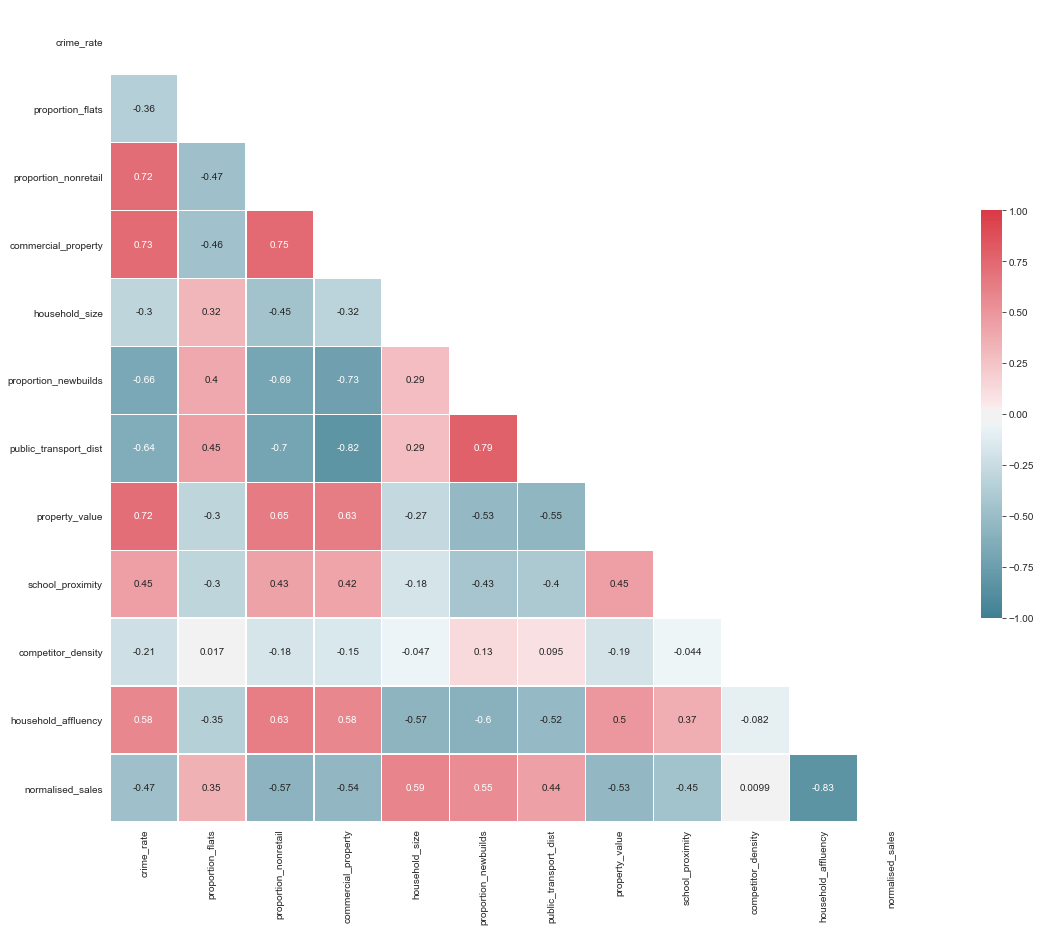

In [362]:
s = stores[all_num]
#whitegrid
sns.set_style('whitegrid')
#compute correlation matrix
corr_matrix=s.corr(method='spearman')
#...and show it with a heatmap
#first define the dimension
plt.figure(figsize=(20,15))

# Generate a mask for the upper triangle
mask = np.zeros_like(corr_matrix, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr_matrix, mask=mask, cmap=cmap, center=0, vmax=1, vmin =-1, annot=True,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

Examine relationship between normalised_sales and a few other variables
-  household_affluency (-0.86)
-  household_size (0.64)
-  proportion_nonretail (-0.59)
-  proportion_newbuilds (0.56)

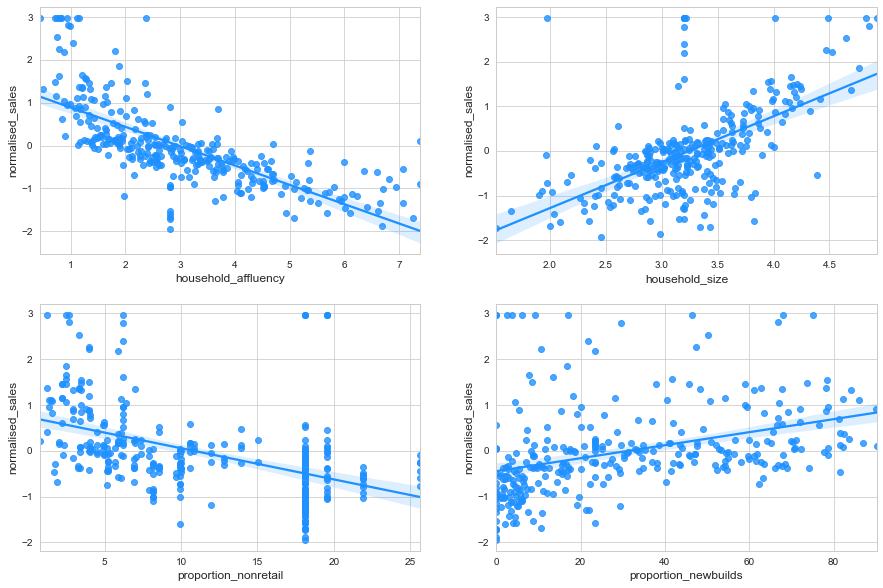

In [363]:
# Scatterplot
f, axes = plt.subplots(figsize = (15,10))
plt.subplot(221)
sns.regplot(data= stores, x='household_affluency', y='normalised_sales')
plt.subplot(222)
sns.regplot(data= stores, x='household_size', y='normalised_sales')
plt.subplot(223)
sns.regplot(data= stores, x='proportion_nonretail', y='normalised_sales')
plt.subplot(224)
sns.regplot(data= stores, x='proportion_newbuilds', y='normalised_sales')

We can see a relationship between normalised_sales, household_size and household_affluency

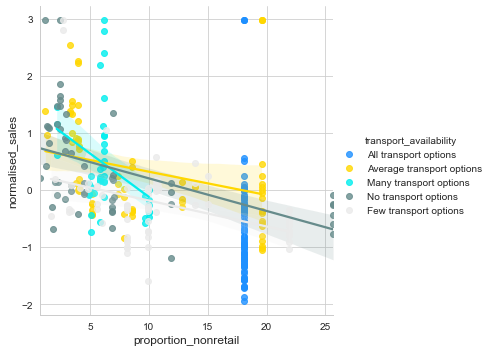

In [364]:
sns.lmplot(data= stores, x='proportion_nonretail', y= 'normalised_sales', hue= 'transport_availability')

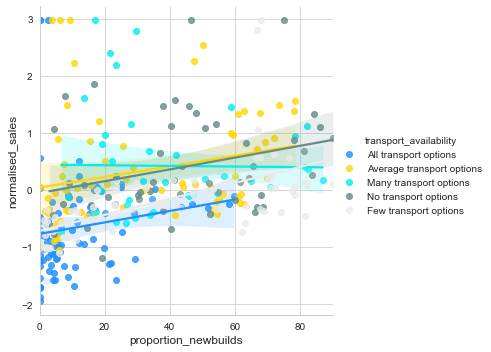

In [365]:
sns.lmplot(data= stores, x='proportion_newbuilds', y= 'normalised_sales', hue= 'transport_availability')

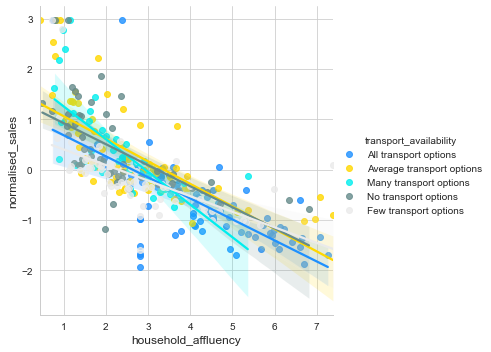

In [366]:
sns.lmplot(data= stores, x='household_affluency', y= 'normalised_sales', hue= 'transport_availability')

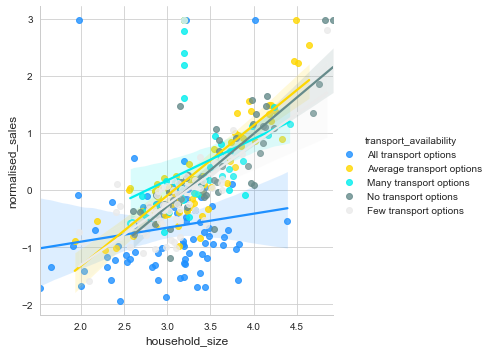

In [367]:
sns.lmplot(data= stores, x='household_size', y= 'normalised_sales', hue= 'transport_availability')

#### Observations from scatterplots and correlation matrix
-  Normalised sales trending down as household affluency goes up
-  Normalised sales trending up as household size goes up
-  When there are many transport options, normalised sales is trending up as the proportion of non retail commercial properties goes down
-  When there are few or no transport options, normalised sales is trending up as proportion of new buils goes up
-  With average transport options and increasing household size, normallised sales seems to be trending up.
-  With decreasing household affluency and many transport options, normalised sales is trending up.

## Q1

Concerns about the data:<br>
-  We can see that the commercial_property feature is missing about 10% of the data and school_proximity is missing about 20%.<br>
-  The balance for several variables.<br><br>

Other useful information to collect:
-  What is the literacy level and educational level of the populations?<br>
-  What languages do they speak and what is the religious structure?<br>
-  Is the health Index weakening?<br>

## Q2

Build a model that can predict store sales based on the provided area features.<br>
Please show how you developed the model and report how well your model is performing.<br>
Constraint: Please use Random Forest as the model family to solve this problem.

In [368]:
# Encode categorical variables
stores_encoded = stores.copy()
stores_encoded["new_store"] = stores_encoded["new_store"].astype('category')
stores_encoded["transport_availability"] = stores_encoded["transport_availability"].astype('category')
stores_encoded["county"] = stores_encoded["county"].astype('category')
stores_encoded["new_store_cat"] = stores_encoded["new_store"].cat.codes
stores_encoded["transport_availability_cat"] = stores_encoded["transport_availability"].cat.codes
stores_encoded["county_cat"] = stores_encoded["county"].cat.codes

In [383]:
stores_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 320 entries, 0 to 319
Data columns (total 19 columns):
 #   Column                      Non-Null Count  Dtype   
---  ------                      --------------  -----   
 0   location_id                 320 non-null    int64   
 1   crime_rate                  320 non-null    float64 
 2   proportion_flats            320 non-null    float64 
 3   proportion_nonretail        320 non-null    float64 
 4   new_store                   320 non-null    category
 5   commercial_property         320 non-null    float64 
 6   household_size              320 non-null    float64 
 7   proportion_newbuilds        320 non-null    float64 
 8   public_transport_dist       320 non-null    float64 
 9   transport_availability      320 non-null    category
 10  property_value              320 non-null    float64 
 11  school_proximity            320 non-null    float64 
 12  competitor_density          320 non-null    float64 
 13  household_affluency 

In [370]:
X = stores_encoded.drop(['normalised_sales', 'new_store', 'transport_availability', 'county'], axis=1)
y = stores_encoded["normalised_sales"].copy()

In [ ]:
# Using Skicit-learn to split data into training and testing sets
# Split the data into training and testing sets
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 0.25, random_state = 42)

In [371]:
#X = stores.copy()
#X = pd.get_dummies(X)

In [372]:
# Display the first 5 rows of the last 12 columns
#X.iloc[:,5:].head(5)

In [373]:
# Labels are the values we want to predict
#y = np.array(X['normalised_sales'])
# Remove the labels from stores_encoded
# axis 1 refers to the columns
#X= X.drop('normalised_sales', axis = 1)
# Saving stores names for later use
#feature_list = list(X.columns)
# Convert to numpy array
#X = np.array(X)

In [384]:
# define the model
#model = RandomForestRegressor() #-0.272
model = RandomForestRegressor(max_samples=None, max_features=7, n_estimators=500, max_depth=None) #-0.270 small gain
# evaluate the model
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(model, X, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1, error_score='raise')
# report performance
print('MAE: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

MAE: -0.270 (0.052)


>10 -0.356 (0.069)
>20 -0.320 (0.065)
>30 -0.301 (0.055)
>40 -0.289 (0.058)
>50 -0.283 (0.057)
>60 -0.279 (0.055)
>70 -0.277 (0.052)
>80 -0.273 (0.055)
>90 -0.271 (0.054)
>100 -0.270 (0.051)


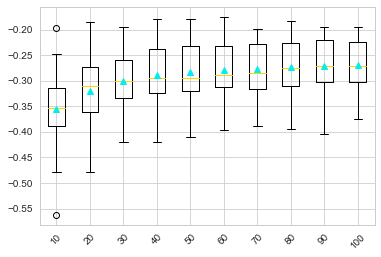

In [375]:
# get a list of models to evaluate
def get_models():
    models = dict()
    models['10'] = RandomForestRegressor(max_samples=0.1)
    models['20'] = RandomForestRegressor(max_samples=0.2)
    models['30'] = RandomForestRegressor(max_samples=0.3)
    models['40'] = RandomForestRegressor(max_samples=0.4)
    models['50'] = RandomForestRegressor(max_samples=0.5)
    models['60'] = RandomForestRegressor(max_samples=0.6)
    models['70'] = RandomForestRegressor(max_samples=0.7)
    models['80'] = RandomForestRegressor(max_samples=0.8)
    models['90'] = RandomForestRegressor(max_samples=0.9)
    models['100'] = RandomForestRegressor(max_samples=None)
    return models
 
# evaluate a give model using cross-validation
def evaluate_model(model):
    cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
    scores = cross_val_score(model, X, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1, error_score='raise')
    return scores
 

# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
    scores = evaluate_model(model)
    results.append(scores)
    names.append(name)
    print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))
# plot model performance for comparison
plt.boxplot(results, labels=names, showmeans=True)
plt.xticks(rotation=45)
plt.show()

>1 -0.332 (0.067)
>2 -0.298 (0.060)
>3 -0.286 (0.056)
>4 -0.277 (0.052)
>5 -0.273 (0.056)
>6 -0.274 (0.053)
>7 -0.273 (0.052)


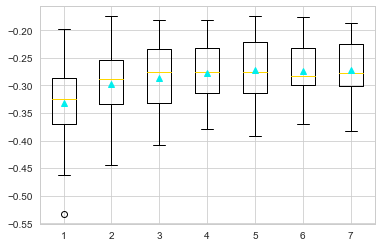

In [376]:
# get a list of models to evaluate
def get_models():
    models = dict()
    models['1'] = RandomForestRegressor(max_features=1)
    models['2'] = RandomForestRegressor(max_features=2)
    models['3'] = RandomForestRegressor(max_features=3)
    models['4'] = RandomForestRegressor(max_features=4)
    models['5'] = RandomForestRegressor(max_features=5)
    models['6'] = RandomForestRegressor(max_features=6)
    models['7'] = RandomForestRegressor(max_features=7)
    return models
 
# evaluate a give model using cross-validation
def evaluate_model(model):
    cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
    scores = cross_val_score(model, X, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1, error_score='raise')
    return scores
 
# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
    scores = evaluate_model(model)
    results.append(scores)
    names.append(name)
    print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))
# plot model performance for comparison
plt.boxplot(results, labels=names, showmeans=True)
plt.show()

>10 -0.284 (0.058)
>50 -0.273 (0.054)
>100 -0.273 (0.055)
>500 -0.271 (0.054)
>1000 -0.270 (0.054)


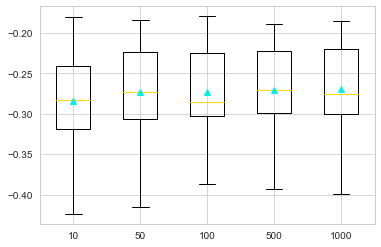

In [377]:
# get a list of models to evaluate
def get_models():
    models = dict()
    models['10'] = RandomForestRegressor(n_estimators=10)
    models['50'] = RandomForestRegressor(n_estimators=50)
    models['100'] = RandomForestRegressor(n_estimators=100)
    models['500'] = RandomForestRegressor(n_estimators=500)
    models['1000'] = RandomForestRegressor(n_estimators=1000)
    return models
 
# evaluate a give model using cross-validation
def evaluate_model(model):
    cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
    scores = cross_val_score(model, X, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1, error_score='raise')
    return scores
 

# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
    scores = evaluate_model(model)
    results.append(scores)
    names.append(name)
    print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))
# plot model performance for comparison
plt.boxplot(results, labels=names, showmeans=True)
plt.show()

>1 -0.496 (0.075)
>2 -0.396 (0.054)
>3 -0.320 (0.053)
>4 -0.293 (0.052)
>5 -0.284 (0.051)
>6 -0.279 (0.055)
>7 -0.279 (0.054)
>None -0.270 (0.054)


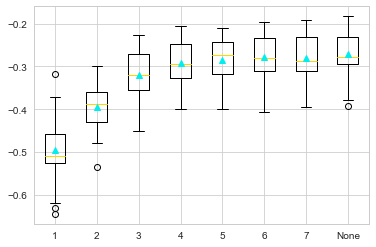

In [378]:
# get a list of models to evaluate
def get_models():
    models = dict()
    models['1'] = RandomForestRegressor(max_depth=1)
    models['2'] = RandomForestRegressor(max_depth=2)
    models['3'] = RandomForestRegressor(max_depth=3)
    models['4'] = RandomForestRegressor(max_depth=4)
    models['5'] = RandomForestRegressor(max_depth=5)
    models['6'] = RandomForestRegressor(max_depth=6)
    models['7'] = RandomForestRegressor(max_depth=7)
    models['None'] = RandomForestRegressor(max_depth=None)
    return models
 
# evaluate a give model using cross-validation
def evaluate_model(model):
    cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
    scores = cross_val_score(model, X, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1, error_score='raise')
    return scores
 
# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
    scores = evaluate_model(model)
    results.append(scores)
    names.append(name)
    print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))
# plot model performance for comparison
plt.boxplot(results, labels=names, showmeans=True)
plt.show()

In [380]:
#X[0]
X.values.tolist()[1]

[504.0,
 0.6035555999999999,
 20.0,
 3.97,
 14.85,
 4.52,
 10.599999999999994,
 2.1398,
 264.0,
 19.1,
 388.37,
 1.815,
 0.0,
 1.0,
 80.0]

In [382]:
#stores.values.tolist()[0]
# define the model
model = RandomForestRegressor(max_samples=None, max_features=7, n_estimators=500, max_depth=None)
#model = RandomForestRegressor()
# fit the model on the whole dataset
model.fit(X, y)
# make a single prediction
#row = [[-0.89483109,-1.0670149,-0.25448694,-0.53850126,0.21082105,1.37435592,0.71203659,0.73093031,-1.25878104,-2.01656886,0.51906798,0.62767387,0.96250155,1.31410617,-1.25527295,-0.85079036,0.24129757,-0.17571721,-1.11454339,0.36268268]]
#yhat = model.predict(row)
yhat = model.predict([X.values.tolist()[1]])
#yhat = model.predict([X[0]])
print('Prediction: {:.7}'.format(yhat[0]))

Prediction: 1.861502


In [ ]:
yhat.dtype

In [ ]:
# Set the style
plt.style.use('fivethirtyeight')
# list of x locations for plotting
x_values = list(range(len(importances)))
# Make a bar chart
plt.bar(x_values, importances, orientation = 'vertical')
# Tick labels for x axis
plt.xticks(x_values, feature_list, rotation='vertical')
# Axis labels and title
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances');